# A simple example of ccs prediction and performance evaluation with pre-trained models

Let us assume that you want to have a look at prediction performance for two different ionmob predictors on data of peptide identifications that came from some source. For ionmob models, you should at least have the following information per peptide: **mz, charge, sequence, ccs**. CCS values are optional in the general case but are required if you want to compare CCS predictions to CCS measurements. We will demonstrate how to do this with one of our provided example datasets.

In [1]:
import os
# suppress CUDA logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from ionmob.preprocess.data import sqrt_model_dataset, to_tf_dataset
from ionmob.preprocess.helpers import tokenizer_from_json

We compare accuracy for two predictors. One that only does a zero-information square-root fit on ion mz values and a deep model that also uses information on peptide sequences. The latter also needs a so-called tokenizer: a tool that translates sequence symbols into a numerical representation. It is specific for a pretrained model and therefore needs to be loaded as well.

In [7]:
# read data to predict ccs values for
data = pd.read_parquet('../../ionmob/data/Tenzer-phospho-train_unimod.parquet')
data

,mz,charge,sequence-tokenized,rt,ccs,name
0,742.8364,2,"[<START>, E, G, S[UNIMOD:21], T, Q, Q, L, Q, T...",10.13,401.834753,Tenzer-phospho-hela
1,880.8602,2,"[<START>, S, A, S[UNIMOD:21], P, Y, P, S, H, S...",14.23,424.740827,Tenzer-phospho-hela
2,587.5807,3,"[<START>, S, A, S[UNIMOD:21], P, Y, P, S, H, S...",14.45,474.251156,Tenzer-phospho-hela
3,723.8784,2,"[<START>, R, S, T[UNIMOD:21], S, P, I, I, G, S...",18.75,397.164339,Tenzer-phospho-hela
4,482.9211,3,"[<START>, R, S, T[UNIMOD:21], S, P, I, I, G, S...",18.66,470.255974,Tenzer-phospho-hela
...,...,...,...,...,...,...
55456,728.2590,3,"[<START>, E, L, V, S[UNIMOD:21], S, S[UNIMOD:2...",17.92,534.128279,Tenzer-phospho-yeast-ttp
55457,592.5737,3,"[<START>, S, H, S, G, S, S[UNIMOD:21], S, P, S...",7.38,468.586429,Tenzer-phospho-yeast-ttp
55458,728.2595,3,"[<START>, E, L, V, S, S, S[UNIMOD:21], S, S, G...",17.39,518.288007,Tenzer-phospho-yeast-ttp
55459,478.5588,3,"[<START>, S[UNIMOD:21], R, S, D, S, P, P, R, Q...",5.57,473.585129,Tenzer-phospho-yeast-ttp


In [10]:
# load models
sqrtModel = tf.keras.models.load_model('../pretrained-models/SqrtModel/')
gruModel = tf.keras.models.load_model('../pretrained-models/GRUPredictor/')

# load tokenizer
tokenizer = tokenizer_from_json('../pretrained-models/tokenizers/tokenizer.json')

# create tf datasets
tensorflow_ds_sqrt = sqrt_model_dataset(data.mz, data.charge, data.ccs).batch(2048)
tensorflow_ds_deep = to_tf_dataset(data.mz, data.charge, 
                                   [list(x) for x in data['sequence-tokenized']], data.ccs, tokenizer, 
                                    batch=False).batch(2048)

# do prediction
ccs_predicted_sqrt = sqrtModel.predict(tensorflow_ds_sqrt)
ccs_predicted_gru, _ = gruModel.predict(tensorflow_ds_deep)

# add predictions to dataset
data['ccs_predicted_sqrt'] = ccs_predicted_sqrt
data['ccs_predicted_gru'] = ccs_predicted_gru

28/28 [==============================] - 2s 67ms/step


Let's compare prediction accuracies.

In [11]:
def mean_abs_error(ccs, ccs_pred):
    return np.round(np.mean([np.abs(x[0] - x[1]) for x in np.c_[ccs, ccs_pred]]), 2)

def mean_perc_error(ccs, ccs_pred):
    return np.round(np.mean([np.abs((x[0] - x[1]) / x[0]) * 100 for x in np.c_[ccs, ccs_pred]]), 2)

print(f"sqrt mean absolute percent error: {mean_perc_error(data.ccs, data.ccs_predicted_sqrt)}")
print(f"gru  mean absolute percent error: {mean_perc_error(data.ccs, data.ccs_predicted_gru)}")
print("")
print(f"sqrt mean absolute error        : {mean_abs_error(data.ccs, data.ccs_predicted_sqrt)}")
print(f"gru  mean absolute error        : {mean_abs_error(data.ccs, data.ccs_predicted_gru)}")

sqrt mean absolute percent error: 4.71
gru  mean absolute percent error: 1.86

sqrt mean absolute error        : 22.1
gru  mean absolute error        : 9.29


Finally, let's visualize the predictions compared to the ccs measurements.

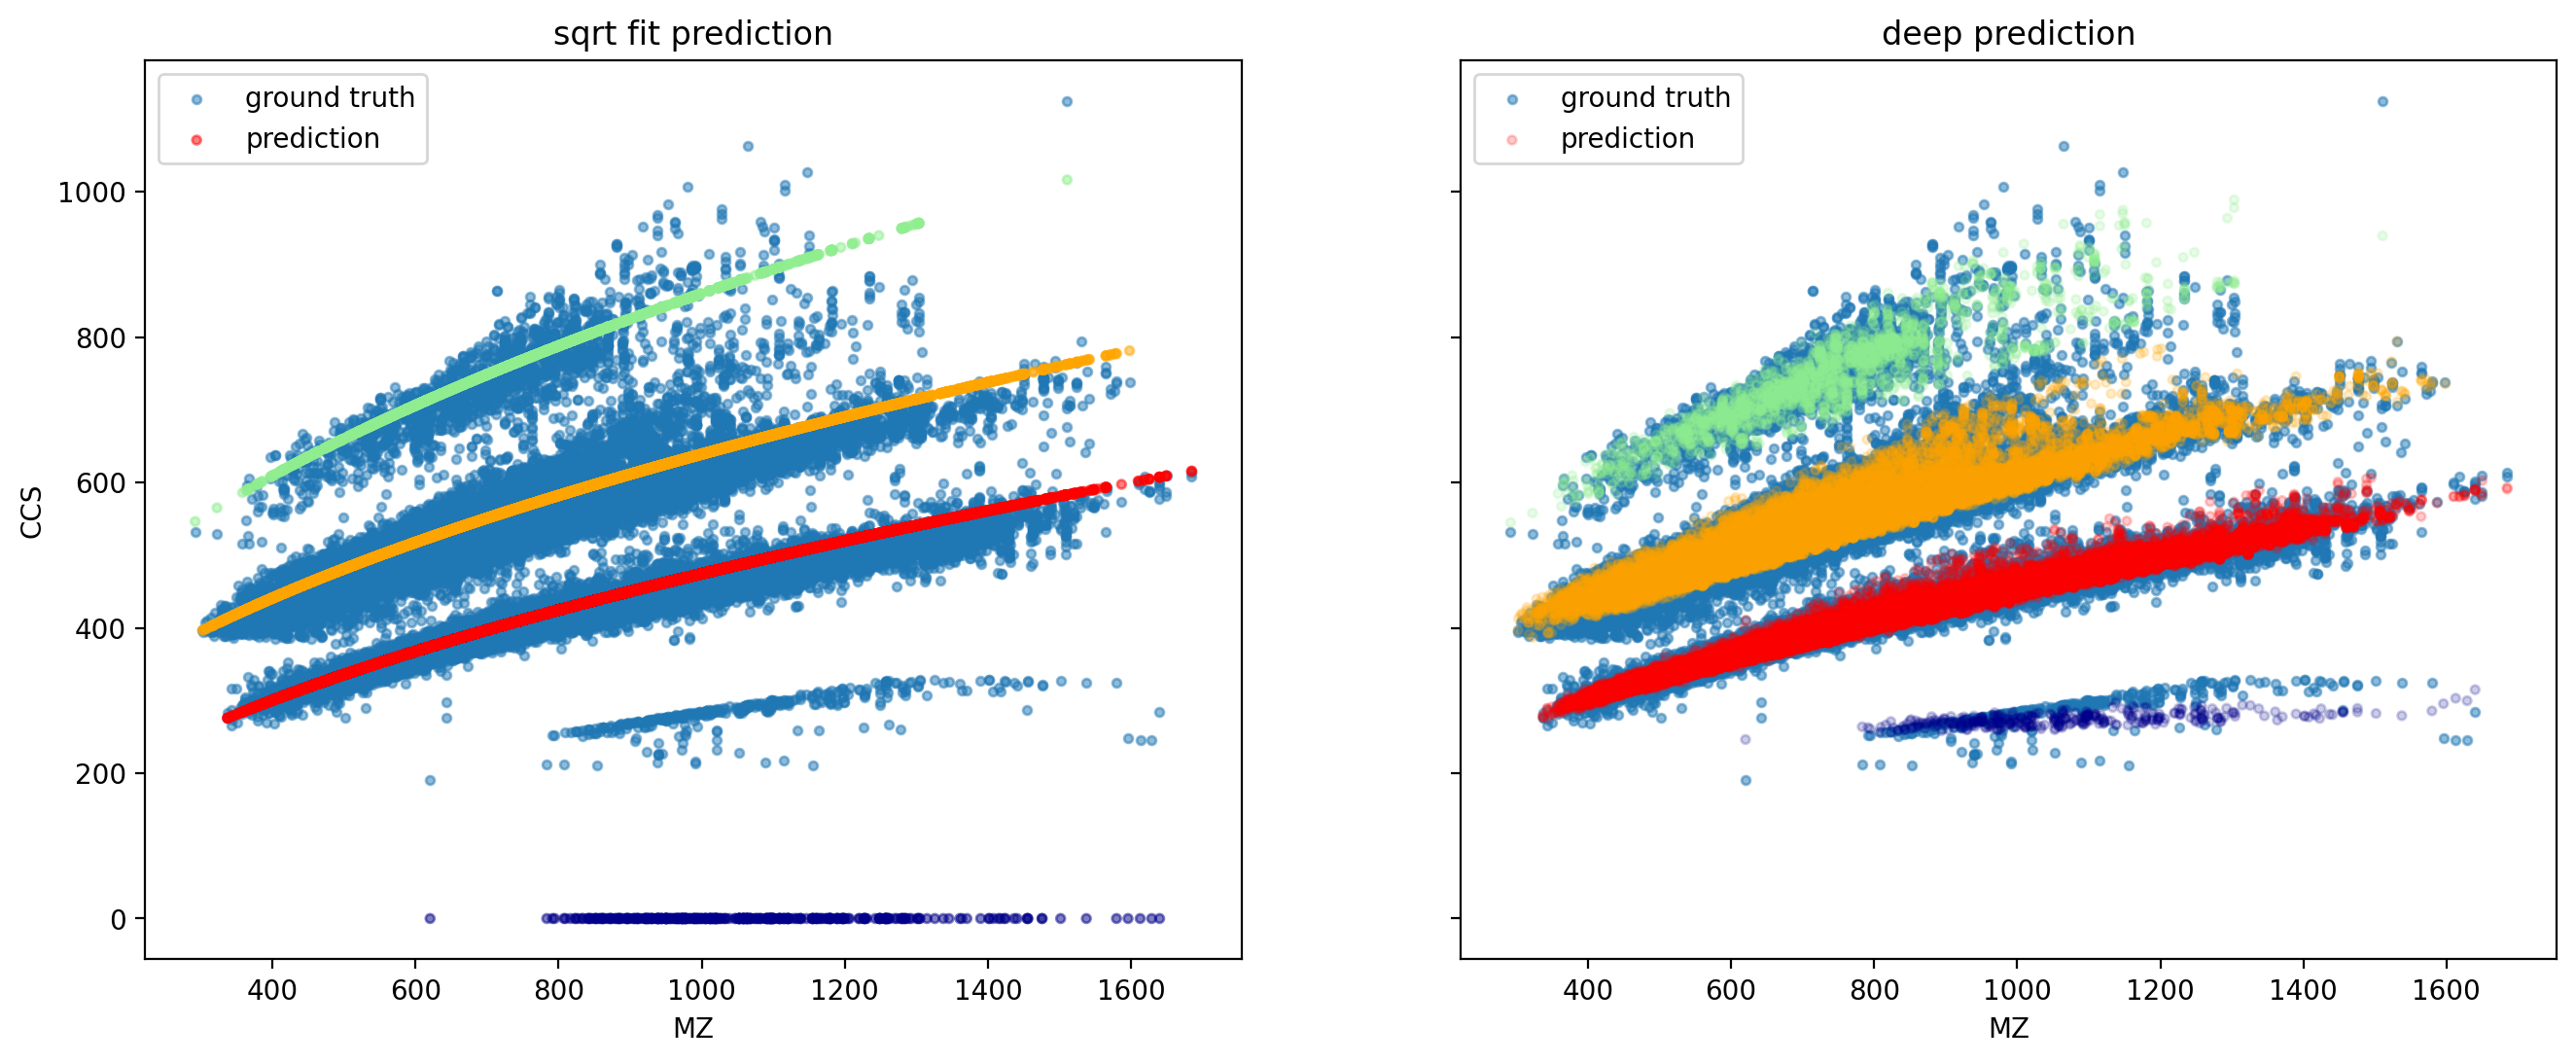

In [12]:
color_dict = {1: 'darkblue', 2:'red', 3:'orange', 4:'lightgreen'}

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), dpi=200, sharey=True, sharex=True)

ax1.set_title('sqrt fit prediction')
ax1.set_ylabel('CCS')
ax1.set_xlabel('MZ')
ax2.set_xlabel('MZ')
ax2.set_title('deep prediction')

ax1.scatter(data.mz, data.ccs, s=10, alpha=.5, label='ground truth')
ax1.scatter(data.mz, data.ccs_predicted_sqrt, s=10, alpha=.5, c=[color_dict[x] for x in data.charge], 
            label='prediction')
ax2.scatter(data.mz, data.ccs, s=10, alpha=.5, label='ground truth')
ax2.scatter(data.mz, data.ccs_predicted_gru, s=10, alpha=.2, c=[color_dict[x] for x in data.charge], 
            label='prediction')

ax1.legend()
ax2.legend()
plt.show()

We could also calculate accuracies with TensorFlow built-ins using model evaluation.

In [13]:
print(gruModel.evaluate(tensorflow_ds_deep))
print(sqrtModel.evaluate(tensorflow_ds_sqrt))

28/28 [==============================] - 3s 69ms/step - loss: 9.6243 - output_1_loss: 9.2930 - output_2_loss: 495.7041 - output_1_mae: 9.2930 - output_1_mean_absolute_percentage_error: 1.8610 - output_2_mae: 495.7041 - output_2_mean_absolute_percentage_error: 102.9152
[9.62432861328125, 9.29295539855957, 495.7040710449219, 9.29295539855957, 1.8609888553619385, 495.7040710449219, 102.91523742675781]
28/28 [==============================] - 1s 4ms/step - loss: 4.7084 - mae: 22.2689
[4.7083539962768555, 22.268911361694336]
